## Setting up a SWAT Connection for Python

In [11]:
import os
import swat

In [12]:
os.environ['CAS_CLIENT_SSL_CA_LIST'] = R"C:\SAS Viya\CAS_ex_cert.crt"

In [13]:
conn = swat.CAS(
    hostname="sas-cas-server-default-bin-demo.uksouth.cloudapp.azure.com",
    port=5570,
    authinfo=R"C:\SAS Viya\authinfo"
)

In [14]:
conn.serverstatus()

NOTE: Grid node action status report: 1 nodes, 8 total actions executed.


[About]

 {'CAS': 'Cloud Analytic Services',
  'Version': '4.00',
  'VersionLong': 'V.04.00M0P09182023',
  'Viya Release': '20230928.1695876470805',
  'Viya Version': 'Stable 2023.09',
  'Copyright': 'Copyright © 2014-2023 SAS Institute Inc. All Rights Reserved.',
  'ServerTime': '2023-10-03T15:47:22Z',
  'System': {'Hostname': 'controller.sas-cas-server-default.sas-viya.svc.cluster.local',
   'OS Name': 'Linux',
   'OS Family': 'LIN X64',
   'OS Release': '5.15.0-1041-azure',
   'OS Version': '#48-Ubuntu SMP Tue Jun 20 20:34:08 UTC 2023',
   'Model Number': 'x86_64',
   'Linux Distribution': 'Red Hat Enterprise Linux release 8.8 (Ootpa)'},
  'license': {'site': 'AMADEUS SOFTWARE LTD VIYA 4',
   'siteNum': 70282179,
   'expires': '30 June 2024 00:00:00',
   'gracePeriod': 30,
   'warningPeriod': 30},
  'CASHostAccountRequired': 'OPTIONAL',
  'Transferred': 'NO',
  'CASCacheLocation': 'CAS Disk Cache'}

[server]

 Server Status
 
    nodes  actions
 0      1        8

[nodestatus]

 Node Status
 
                                                 name        role  uptime  running  stalled
 0  controller.sas-cas-server-default.sas-viya.svc...  controller   1.868        0        0

+ Elapsed: 0.000868s, sys: 0.000819s, mem: 0.309mb

## Create a reference to in-memory tables

In [15]:
gyms = conn.CASTable("gym_summary", caslib="public")
members = conn.CASTable("members", caslib="public")

## Use pandas code and functions on the CAS tables as if they were standard dataframes

These will be translated into CAS actions, and alter the underlying table in CAS

In [16]:
# Get head data from table, methods similar to pandas
gyms.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1.0,400.0,D,D-penicillamine,21464.0,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2.0,4500.0,C,D-penicillamine,20617.0,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3.0,1012.0,D,D-penicillamine,25594.0,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4.0,1925.0,D,D-penicillamine,19994.0,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5.0,1504.0,CL,Placebo,13918.0,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [17]:
# Work with the tables as if they were pandas dataframes

gyms["achieving_target"] = gyms["members_net_change"] > 0

In [ ]:
members_subset = members[members.country == "England"]
members_subset.head()

## Use the full capabilities of CAS

Can load in Action Sets to perform any CAS action, i.e. powerful in-memory & distributed analysis

In [18]:
conn.loadactionset("regression")

NOTE: Added action set 'regression'.


[actionset]

 'regression'

+ Elapsed: 0.00518s, sys: 0.00513s, mem: 0.296mb

In [23]:
ouput = gyms.glm(target = "total_revenue",
         inputs = ["achieving_target", "Gym_Size", "Gym_Current_Members"],
         output = {
             "casOut": {"name": "RevenuePrediction", "replace": True},
             "copyvars": "all",
             "pred": "Predicted_Revenue",
         }
)

In [24]:
result = conn.CASTable("RevenuePrediction")

In [25]:
result.head()

,PredictedPlatelets,ResidualPlatelets,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Bilirubin_high
0,202.666523,-12.666523,1.0,400.0,D,D-penicillamine,21464.0,F,Y,Y,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,1.0
1,293.208013,-72.208013,2.0,4500.0,C,D-penicillamine,20617.0,F,N,Y,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,0.0
2,225.155718,-74.155718,3.0,1012.0,D,D-penicillamine,25594.0,M,N,N,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0,1.0
3,192.412022,-9.412022,4.0,1925.0,D,D-penicillamine,19994.0,F,N,Y,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,1.0
4,301.813246,-165.813246,5.0,1504.0,CL,Placebo,13918.0,F,N,Y,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0,1.0


<Axes: xlabel='PredictedPlatelets', ylabel='Platelets'>

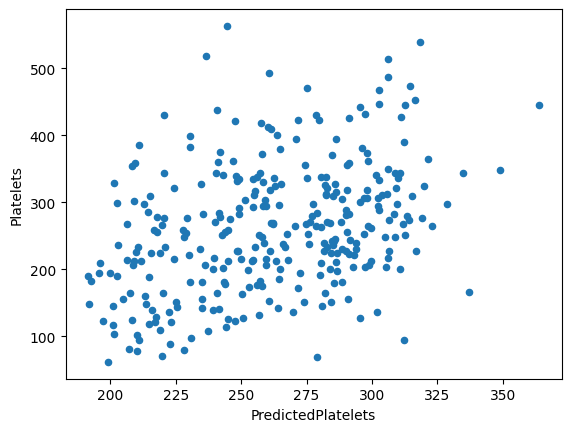

In [26]:
result.plot.scatter("Predicted_Revenue", "total_revenue")